In [1]:
from utils import *
from IPython.display import HTML, display

In [2]:
from fastai2.text.all import *
import pandas as pd

In [5]:
# path = Path('.')
df = pd.read_csv('titles_only.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
n = df.count()[0]
is_val = [True for i in range(df.count()[0])]
idx = [random.randint(0, n-1) for i in range(int(0.8*n))]

In [7]:
for i in idx:
    is_val[i] = False

len(is_val) == n

True

In [8]:
df['is_valid'] = is_val

In [10]:
df = df.rename(columns={"title": "text", "flair": "label"})
print(df.head())

           label  \
0  [R]eddiquette   
1       Politics   
2       Politics   
3    Coronavirus   
4  Non-Political   

                                                                                                                                text  \
0                                    Will donate thrice the number of upvotes (amount in Rs.) i get for this thread in next 24 hours   
1                                                                                                                  Fuck all Religion   
2  German exchange Student at IIT Madras is being sent back home by the Indian immigration department because he joined the protest.   
3                                                                                                                  Today's The Hindu   
4                                                                If you are not moved by this picture, I wish I had your heart. [NP]   

   is_valid  
0     False  
1     False  
2     False  
3     

In [12]:
db = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                     get_x=ColReader('text'),
                     splitter=ColSplitter()).dataloaders(df, bs=64, seq_len=72)
print(db.show_batch(max_n=6))

,text,text_
0,"xxbos xxmaj bengaluru traffic cop stops xxmaj president ’s xxunk to let ambulance xxunk ; wins xxunk and xxunk too xxbos xxmaj in an xxunk xxunk society of xxmaj india , xxunk xxunk xxunk people about dog xxunk ! xxbos a xxunk xxunk celebrating xxmaj xxunk in xxmaj bengaluru ! ! xxbos xxmaj xxunk xxunk xxunk , xxunk xxunk beautiful . xxbos xxmaj xxunk work an family like a xxunk xxbos xxmaj","xxmaj bengaluru traffic cop stops xxmaj president ’s xxunk to let ambulance xxunk ; wins xxunk and xxunk too xxbos xxmaj in an xxunk xxunk society of xxmaj india , xxunk xxunk xxunk people about dog xxunk ! xxbos a xxunk xxunk celebrating xxmaj xxunk in xxmaj bengaluru ! ! xxbos xxmaj xxunk xxunk xxunk , xxunk xxunk beautiful . xxbos xxmaj xxunk work an family like a xxunk xxbos xxmaj deccan"
1,"so short and clear . xxmaj this is heart - xxunk , xxunk and too xxunk ! xxbos xxmaj into the xxmaj xxunk . ( mumbai edition ) xxbos i xxunk most of xxmaj xxunk inside xxmaj india xxbos "" xxunk "" ( 4 xxrep 3 0 xxunk xxrep 3 0 | xxmaj xxunk xxmaj xxunk , xxmaj hyderabad ) xxbos xxmaj why is that ? xxbos xxup xxunk and its xxmaj","short and clear . xxmaj this is heart - xxunk , xxunk and too xxunk ! xxbos xxmaj into the xxmaj xxunk . ( mumbai edition ) xxbos i xxunk most of xxmaj xxunk inside xxmaj india xxbos "" xxunk "" ( 4 xxrep 3 0 xxunk xxrep 3 0 | xxmaj xxunk xxmaj xxunk , xxmaj hyderabad ) xxbos xxmaj why is that ? xxbos xxup xxunk and its xxmaj xxunk"
2,"view from my xxunk while i leave my xxunk to xxunk xxunk , xxunk xxunk xxunk this place the xxunk 15 xxunk xxbos xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk and xxmaj xxunk xxmaj xxunk welcome you to xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj college , xxmaj xxunk , xxmaj kerala . xxbos xxmaj just saw this on a temple . xxbos xxmaj xxunk like xxunk sense of xxunk","from my xxunk while i leave my xxunk to xxunk xxunk , xxunk xxunk xxunk this place the xxunk 15 xxunk xxbos xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk and xxmaj xxunk xxmaj xxunk welcome you to xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj college , xxmaj xxunk , xxmaj kerala . xxbos xxmaj just saw this on a temple . xxbos xxmaj xxunk like xxunk sense of xxunk amidst"
3,"xxunk and a xxunk , do xxunk xxunk generated by xxunk . xxbos xxmaj manmohan xxmaj singh on xxmaj xxunk , xxmaj xxunk rape cases : "" pm xxmaj modi should xxunk own advice to me , speak more xxunk "" xxbos xxmaj muslim xxunk came , xxunk the xxunk & also xxunk "" ram xxmaj xxunk xxmaj xxunk xxunk "" in the xxunk xxunk of a xxmaj hindu xxmaj man ,","and a xxunk , do xxunk xxunk generated by xxunk . xxbos xxmaj manmohan xxmaj singh on xxmaj xxunk , xxmaj xxunk rape cases : "" pm xxmaj modi should xxunk own advice to me , speak more xxunk "" xxbos xxmaj muslim xxunk came , xxunk the xxunk & also xxunk "" ram xxmaj xxunk xxmaj xxunk xxunk "" in the xxunk xxunk of a xxmaj hindu xxmaj man , xxmaj"
4,"is xxunk xxunk or ' xxunk . xxmaj it 'll be xxunk if the father is born after the child … "" xxbos 500 rupee and 1 xxrep 3 0 rupee xxunk notes wo n't be legal xxunk any more xxbos xxmaj is this what we are xxunk into ? xxbos xxmaj finally , i was xxunk to change my xxmaj dad 's xxunk on xxup bjp .. xxbos xxmaj hindu man","xxunk xxunk or ' xxunk . xxmaj it 'll be xxunk if the father is born after the child … "" xxbos 500 rupee and 1 xxrep 3 0 rupee xxunk notes wo n't be legal xxunk any more xxbos xxmaj is this what we are xxunk into ? xxbos xxmaj finally , i was xxunk to change my xxmaj dad 's xxunk on xxup bjp .. xxbos xxmaj hindu man gets"
5,"r / xxmaj india , xxmaj i 've been doing some xxunk , xxunk xxunk of countries ' flags , here 's xxunk ] xxbos xxmaj social distancing in vegetable xxunk in xxmaj xxunk , xxmaj andhra xxbos a public xxunk from a xxunk doctor of xxmaj xxunk hospital in xxmaj delhi . # xxup xxunk xxbos xxmaj this is massive ! xxmaj india wins xxunk medals at xxmaj special xxmaj xxunk","/ xxmaj india , xxmaj i 've been doing some

None


In [13]:
dls = db.dataloaders(df, bs=64, seq_len=72)
dls.show_batch(max_n=6)

,text,text_
0,"xxbos xxup gslv xxmaj xxunk 3 launch as xxunk from my office in xxmaj chennai . xxbos xxmaj russia xxunk xxmaj india , says xxup xxunk move ' xxunk out within xxunk of xxmaj xxunk ' xxbos xxmaj xxunk ! xxbos i started my xxmaj xxunk degree yesterday at the xxunk of 25 . xxbos xxmaj xxunk xxunk xxbos xxmaj into the xxmaj xxunk . ( mumbai edition ) xxbos xxmaj found","xxup gslv xxmaj xxunk 3 launch as xxunk from my office in xxmaj chennai . xxbos xxmaj russia xxunk xxmaj india , says xxup xxunk move ' xxunk out within xxunk of xxmaj xxunk ' xxbos xxmaj xxunk ! xxbos i started my xxmaj xxunk degree yesterday at the xxunk of 25 . xxbos xxmaj xxunk xxunk xxbos xxmaj into the xxmaj xxunk . ( mumbai edition ) xxbos xxmaj found this"
1,xxunk of xxmaj rs 2 xxrep 4 0 crore . > xxmaj free xxmaj xxunk to all for a month . > 2 months ’ xxunk to be given xxunk . > xxmaj one month xxunk to xxunk water & power xxunk . > xxmaj xxunk xxunk of xxmaj rs 500 crore . > xxmaj xxunk xxup xxunk cases in the state is 25 xxbos xxmaj artist xxmaj xxunk xxmaj xxunk xxunk,of xxmaj rs 2 xxrep 4 0 crore . > xxmaj free xxmaj xxunk to all for a month . > 2 months ’ xxunk to be given xxunk . > xxmaj one month xxunk to xxunk water & power xxunk . > xxmaj xxunk xxunk of xxmaj rs 500 crore . > xxmaj xxunk xxup xxunk cases in the state is 25 xxbos xxmaj artist xxmaj xxunk xxmaj xxunk xxunk an
2,"one lakh people have a xxrep 3 s xxunk . xxmaj say it is a xxunk meet . xxbos xxmaj xxunk xxmaj kerala , by xxmaj pencilashan xxbos xxmaj when your friends from the other species xxunk your wedding .. xxbos xxmaj modiji is xxunk because we have xxmaj real xxmaj xxunk # xxunk xxbos xxmaj no xxmaj yoga and xxmaj yoga . xxmaj xxunk xxbos xxmaj welcome to xxmaj indian xxmaj","lakh people have a xxrep 3 s xxunk . xxmaj say it is a xxunk meet . xxbos xxmaj xxunk xxmaj kerala , by xxmaj pencilashan xxbos xxmaj when your friends from the other species xxunk your wedding .. xxbos xxmaj modiji is xxunk because we have xxmaj real xxmaj xxunk # xxunk xxbos xxmaj no xxmaj yoga and xxmaj yoga . xxmaj xxunk xxbos xxmaj welcome to xxmaj indian xxmaj education"
3,"to xxunk this magnificent xxunk in xxmaj xxunk , xxmaj kerala - xxunk - iphone xxbos xxmaj why are you running , you asked for it ? xxbos xxmaj fuck all xxmaj religion xxbos [ np ] i see your xxmaj xxunk and xxunk you a little down south to xxmaj kashmir xxmaj xxunk . xxbos xxmaj found this in the xxunk of xxmaj hyderabad . xxmaj it works . xxbos xxmaj","xxunk this magnificent xxunk in xxmaj xxunk , xxmaj kerala - xxunk - iphone xxbos xxmaj why are you running , you asked for it ? xxbos xxmaj fuck all xxmaj religion xxbos [ np ] i see your xxmaj xxunk and xxunk you a little down south to xxmaj kashmir xxmaj xxunk . xxbos xxmaj found this in the xxunk of xxmaj hyderabad . xxmaj it works . xxbos xxmaj hindu"
4,"been trying to xxunk this for years now . xxmaj xxunk in xxunk , "" xxunk "" xxbos xxmaj xxunk xxmaj dog xxunk the lives of 30 xxmaj people in xxup up xxbos [ oc ] i painted a mural . xxbos xxmaj cartoon : xxmaj how xxmaj india 's xxup nrc xxunk xxup cab xxunk xxunk for xxmaj muslims . xxbos xxmaj the new xxunk rupee note ! xxmaj clear xxunk","trying to xxunk this for years now . xxmaj xxunk in xxunk , "" xxunk "" xxbos xxmaj xxunk xxmaj dog xxunk the lives of 30 xxmaj people in xxup up xxbos [ oc ] i painted a mural . xxbos xxmaj cartoon : xxmaj how xxmaj india 's xxup nrc xxunk xxup cab xxunk xxunk for xxmaj muslims . xxbos xxmaj the new xxunk rupee note ! xxmaj clear xxunk from"
5,"xxunk , no xxunk for xxunk workers . xxmaj that 's how building xxunk works in our country xxbos xxmaj tesla xxmaj xxunk xxmaj xxunk xxbos a xxmaj hero xxmaj will xxmaj xxunk , digital art by xxmaj xxunk xxmaj xxunk xxbos xxmaj xxunk students can xxunk xxbos xxmaj back in the day , almost every xxunk in xxmaj india had one of these ! xxbos xxmaj this is xxunk xxunk .",", no xxunk for xxunk workers . xxmaj that 's how building xxun

In [14]:
db_clas = DataBlock(blocks=(TextBlock.from_df('text',seq_len=72, vocab=dls.vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'),
                    splitter=ColSplitter())

In [15]:
dls_clas = db_clas.dataloaders(df, bs=64)
dls_clas.show_batch(max_n=6)

,text,category
0,xxbos xxmaj from xxmaj kerala xxunk 's xxmaj xxunk xxmaj xxunk . > xxmaj financial xxunk of xxmaj rs 2 xxrep 4 0 crore . > xxmaj free xxmaj xxunk to all for a month . > 2 months ’ xxunk to be given xxunk . > xxmaj one month xxunk to xxunk water & power xxunk . > xxmaj xxunk xxunk of xxmaj rs 500 crore . > xxmaj xxunk xxup xxunk cases in the state is 25,Coronavirus
1,"xxbos xxmaj life xxmaj pro xxmaj xxunk xxmaj india - xxmaj if you 're getting xxunk with "" xxunk xxmaj xxunk "" xxunk , do n't xxunk up or pick and xxunk xxunk the call . xxmaj pick the call , say you want the xxunk xxunk and tell them you 're xxunk and do n't have any xxunk . xxmaj they 're xxunk you as xxmaj xxunk on their xxup xxunk and xxunk clear of you .",Non-Political
2,xxbos [ np ] xxmaj this is xxmaj xxunk . xxmaj the xxmaj ambulance xxmaj driver who xxunk xxunk xxunk in 6 hours from xxunk xxunk of xxmaj kerala to the xxmaj xxunk end . xxmaj the ambulance was taking a xxunk day old baby from xxmaj xxunk xxmaj medical xxmaj college ( xxunk ) to xxup xxunk xxmaj hospital ( xxunk ) . xxmaj the ambulance xxunk xxup xxunk at xxunk today morning .,Non-Political
3,xxbos xxmaj that ’s my xxunk . xxmaj he was beaten and xxunk at xxmaj xxunk xxmaj metro xxmaj station just because he was asked his name and he replied xxmaj abdul xxmaj xxunk xxmaj khan . xxmaj please tell me that the xxunk of xxunk xxunk by the xxunk of this country shall not reach me . xxmaj it has xxunk . xxmaj and it xxunk reach you next . xxunk xxunk,Unverified
4,"xxbos xxmaj rape of xxunk - old in xxmaj bengaluru : xxmaj xxunk of medical report and top xxunk 's xxunk gets accused off the xxunk . xxmaj the defence first xxunk that the child – the xxunk - year - old – was xxunk xxunk . xxmaj when this line was xxunk to , the defence xxunk that she had a xxunk xxunk . [ xxunk . ' xxunk ]",Non-Political
5,"xxbos xxup xxunk : xxmaj documents xxmaj show xxmaj modi xxmaj govt xxmaj building xxunk xxmaj degree xxmaj xxunk xxmaj to xxmaj xxunk xxmaj every xxmaj indian : xxmaj documents xxunk under xxup xxunk show the govt is xxunk to use xxmaj aadhaar to xxunk xxunk every single xxmaj indian – from who they xxunk , address xxunk , financial xxunk – xxunk the xxmaj national xxmaj social xxmaj xxunk .",Politics


In [42]:
learn = text_classifier_learner(dls_clas, AWD_LSTM).to_fp16()

In [43]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,time
0,2.836569,2.573108,00:01


In [44]:
learn.save('1epoch')

In [45]:
learn = learn.load('1epoch')

In [46]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,time
0,2.646012,2.601434,00:01
1,2.419025,2.503597,00:01
2,2.151600,2.459481,00:01
3,1.891681,2.178750,00:01
4,1.608586,1.946914,00:01
5,1.376270,2.050924,00:01
6,1.187871,2.093295,00:01
7,1.033096,2.085832,00:01
8,0.902921,2.037826,00:01
9,0.797313,2.074220,00:01


In [47]:
learn.unfreeze()
learn.fit_one_cycle(6, 2e-3)

epoch,train_loss,valid_loss,time
0,0.305075,2.017343,00:01
1,0.337997,2.923476,00:01
2,0.347018,2.645471,00:01
3,0.347965,2.531540,00:01
4,0.324167,2.418219,00:01
5,0.283112,2.303399,00:01


In [48]:
learn.save_encoder('titles_model')

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=1.0964781722577754e-06)

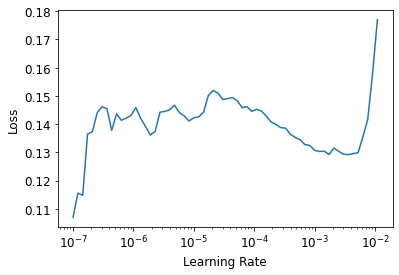

In [49]:
learn.lr_find()

In [81]:
# from fastai2.vision.all import *
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(dls_clas, preds, y , losses)

In [50]:
learn = learn.load_encoder('titles_model')

In [54]:
predictor = learn.predict("lockdown birthdays can be fun!")

In [55]:
predictor

('Non-Political',
 tensor(4),
 tensor([0.0076, 0.0105, 0.0368, 0.0182, 0.8245, 0.0160, 0.0044, 0.0237, 0.0106, 0.0183, 0.0148, 0.0063, 0.0082]))

In [58]:
learn.export('titles_model.pkl')